In [1]:
import pandas as pd
import csv
from zipfile import ZipFile
import vaex
import dask 
import dask.dataframe as dd
import pylab as plt
import seaborn as sns
import numpy as np
import os, h5py

INFO:MainThread:numexpr.utils:NumExpr defaulting to 8 threads.


## Read all csv fiels from given zip file

Reading green.zip without extracting it, concatenating all csv file into single pandas dataframe and coverting them to hdf

In [2]:
zip_file = ZipFile('/Users/gaurikulkarni/Downloads/green.zip')

list_df =[]
dir = "green/green_tripdata"
count = 0
for text_file in zip_file.infolist():
    if dir in text_file.filename:
#         print(text_file.filename)
        count += 1
        df_read = pd.read_csv(zip_file.open(text_file.filename),sep=',',skip_blank_lines=True,usecols=range(5,13),index_col=False,low_memory=False).rename(str.lower,axis=1)
        list_df.append(df_read)
print(count)

76


In [3]:
df_data = pd.concat(list_df,axis=0, ignore_index=True,sort=False)

### Implement gracbage collectio to free memory 

In [4]:
import gc
list_df = 0
gc.collect()
gc.get_stats()

[{'collections': 613, 'collected': 31190, 'uncollectable': 0},
 {'collections': 56, 'collected': 4300, 'uncollectable': 0},
 {'collections': 6, 'collected': 344, 'uncollectable': 0}]

In [5]:
panda_df = df_data.drop(['pulocationid','dolocationid','extra','mta_tax','tip_amount'],1).dropna(subset=["pickup_longitude"])

In [ ]:
df_data = 0
gc.collect()
gc.get_stats()
panda_df

## Pandas dataframe to HDF

In [7]:
panda_df.to_hdf("/Users/gaurikulkarni/Downloads/database_pandas.h5",'data')

## Pandas dataframe to Vaex HDF

In [8]:
vaex_df = vaex.from_pandas(panda_df, copy_index=False)
        
# Export the data with vaex to hdf5
vaex_df.export_hdf5(path='/Users/gaurikulkarni/Downloads/database_vaex.h5', progress=False)

## Pandas dataframe to Dask HDF

In [9]:
dask_df = dd.from_pandas(panda_df,chunksize=10000)
dask_df.to_hdf('/Users/gaurikulkarni/Downloads/database_dask.h5','data')

['/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gaurikulkarni/Downloads/database_dask.h5',
 '/Users/gau

Clear combined data using garbage collection 

In [10]:
panda_df = 0
gc.collect()
gc.get_stats()

[{'collections': 1042, 'collected': 96330, 'uncollectable': 0},
 {'collections': 95, 'collected': 12743, 'uncollectable': 0},
 {'collections': 10, 'collected': 992, 'uncollectable': 0}]

## Read hdf files  

### Read Pandas hdf

In [12]:
panda_hdf_read = pd.read_hdf('/Users/gaurikulkarni/Downloads/database_pandas.h5','data')

### Read Vaex hdf

In [13]:
df_vaex = vaex.open('/Users/gaurikulkarni/Downloads/database_vaex.h5')

### Read Dask hdf

In [2]:
df_dask_read = dd.read_hdf('/Users/gaurikulkarni/Downloads/database_dask.h5', key='data', chunksize=10000, mode='r', sorted_index=False)
df_dask_read.mean().compute()

passenger_count       1.393247
trip_distance         2.898160
fare_amount          12.330204
pickup_longitude    -73.817276
pickup_latitude      40.687114
dropoff_longitude   -73.823056
dropoff_latitude     40.688422
dtype: float64

### 1. Plot the number of unique trips with certain number of passengers in the entire green taxi data. 

### Reading data from Pandas hdf

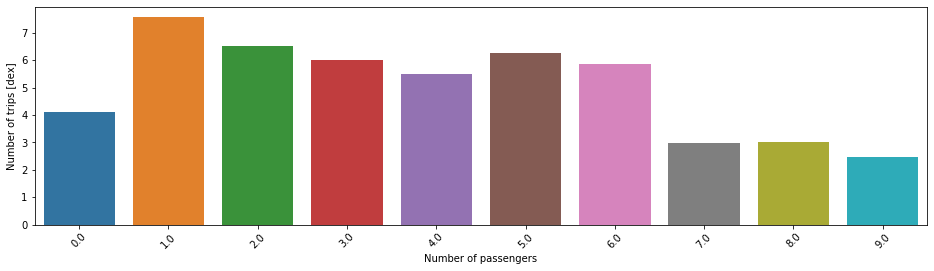

passenger_count
0.0       12797
1.0    36678194
2.0     3280370
3.0     1018470
4.0      310234
5.0     1874464
6.0      701253
7.0         961
8.0        1066
9.0         295
dtype: int64
19.9 ns ± 0.623 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [15]:
def passengerCount():
    num_passengers = panda_hdf_read.groupby('passenger_count').size()
    plt.figure(figsize=(16, 4))
    sns.barplot(x=num_passengers.index, y=np.log10(num_passengers.values))
    plt.xlabel('Number of passengers')
    plt.ylabel('Number of trips [dex]')
    plt.xticks(rotation='45')
    plt.show()
    print(num_passengers)
    return num_passengers
function_performance = passengerCount()
%timeit function_performance

### Reading data from Vaex hdf

[########################----------------] 100.00% elapsed time  :     0.28s =  0.0m =  0.0h
 

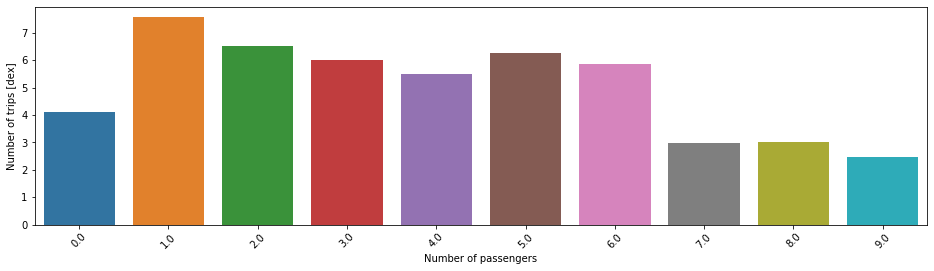

1.0    36678194
2.0     3280370
5.0     1874464
3.0     1018470
6.0      701253
4.0      310234
0.0       12797
8.0        1066
7.0         961
9.0         295
dtype: int64

In [16]:
num_passengers_vaex = df_vaex.passenger_count.value_counts(progress=True)

# Plot the result
plt.figure(figsize=(16, 4))
sns.barplot(x=num_passengers_vaex.index, y=np.log10(num_passengers_vaex.values))
plt.xlabel('Number of passengers')
plt.ylabel('Number of trips [dex]')
plt.xticks(rotation='45')
plt.show()

num_passengers_vaex

### Reading data from Dask hdf

In [17]:
def passengerCountDask():
    dask_num_passengers = df_dask_read.groupby('passenger_count')['passenger_count'].count().compute()
    dask_num_passengers.plot(kind='bar')
    print(dask_num_passengers)
%timeit dask.delayed(passengerCountDask)

12.1 µs ± 103 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


passenger_count
0.0       12797
1.0    36678194
2.0     3280370
3.0     1018470
4.0      310234
5.0     1874464
6.0      701253
8.0        1066
7.0         961
9.0         295
Name: passenger_count, dtype: int64

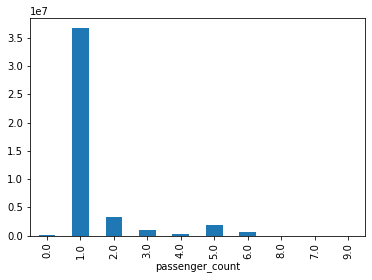

In [18]:
dask.delayed(df_dask_read.groupby('passenger_count')['passenger_count'].count().compute().plot(kind='bar'))
dask_num_passengers = df_dask_read.groupby('passenger_count')['passenger_count'].count().compute()
dask_num_passengers

# Analysis: 

Vaex: 0.28s =  0.0m =  0.0h

Dask: 12.1 µs ± 103 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each), so runtime will be aroud 1.2s

Pandas: 19.9 ns ± 0.623 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each), so runtime will be aroud 1.99s

As per the above runtime analysis, vaex is faster than daks and pandas with green taxi data. 

## 2.Filter out the trips longer than 100 miles and trips that claim more than 10 people.

### Reading data from Pandas hdf

In [19]:
def trip_distance_pandas():
    pandas_distance = pd.DataFrame(panda_hdf_read)
    # df_distance = df_distance[(df_distance.trip_distance < 100) & (df_distance.passenger_count > 0)]
    pandas_distance = pandas_distance[(pandas_distance.passenger_count > 0) & (pandas_distance.passenger_count <= 10)& (pandas_distance.trip_distance > 0) & (pandas_distance.trip_distance <= 100)]
    return pandas_distance
pdf_distance = trip_distance_pandas()
%timeit pdf_distance
pdf_distance

19.6 ns ± 0.387 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


,passenger_count,trip_distance,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
2199568,1.0,0.25,3.0,-73.949959,40.827183,-73.952377,40.824036
2199569,1.0,0.04,2.5,-73.944977,40.808582,-73.945923,40.807316
2199570,1.0,0.26,3.0,-73.951561,40.812111,-73.952171,40.812458
2199571,1.0,0.51,4.0,-73.952080,40.790131,-73.947639,40.795391
2199572,5.0,0.26,3.0,-73.913895,40.683006,-73.913887,40.684761
...,...,...,...,...,...,...,...
75903985,1.0,5.00,15.0,-73.997559,40.691139,-73.940086,40.723503
75903986,2.0,2.10,9.0,-73.890846,40.746918,-73.862122,40.739246
75903987,1.0,6.40,25.0,-73.956848,40.722839,-74.004005,40.721066
75903988,4.0,4.60,19.5,-73.981323,40.675045,-73.992836,40.724155


### Reading data from Vaex hdf

In [20]:
%timeit df_vaex[(df_vaex.passenger_count > 0) & (df_vaex.passenger_count <= 10)& (df_vaex.trip_distance > 0) & (df_vaex.trip_distance <= 100)]
df_filtered_vaex = df_vaex[(df_vaex.passenger_count > 0) & (df_vaex.passenger_count <= 10)& (df_vaex.trip_distance > 0) & (df_vaex.trip_distance <= 100)]
df_filtered_vaex

11.8 ms ± 4.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#,passenger_count,trip_distance,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,1.0,0.25,3.0,-73.94995880126955,40.82718276977539,-73.95237731933594,40.82403564453125
1,1.0,0.04,2.5,-73.94497680664062,40.8085823059082,-73.9459228515625,40.807315826416016
2,1.0,0.26,3.0,-73.9515609741211,40.812110900878906,-73.95217132568358,40.81245803833008
3,1.0,0.51,4.0,-73.95207977294923,40.790130615234375,-73.94763946533203,40.79539108276367
4,5.0,0.26,3.0,-73.9138946533203,40.683006286621094,-73.91388702392578,40.68476104736328
...,...,...,...,...,...,...,...
"43,217,484",1.0,5.0,15.0,-73.99755859375,40.691139221191406,-73.9400863647461,40.72350311279297
"43,217,485",2.0,2.1,9.0,-73.8908462524414,40.746917724609375,-73.86212158203125,40.7392463684082
"43,217,486",1.0,6.4,25.0,-73.95684814453125,40.72283935546875,-74.0040054321289,40.72106552124024
"43,217,487",4.0,4.6,19.5,-73.9813232421875,40.67504501342773,-73.99283599853516,40.72415542602539


### Reading data from Dask hdf

In [21]:
def filterd_Dask():
    df_filtered_dask = df_dask_read[(df_dask_read.passenger_count > 0) & (df_dask_read.passenger_count <= 10)& (df_dask_read.trip_distance > 0) & (df_dask_read.trip_distance <= 100)]
    print(df_filtered_dask)
%timeit dask.delayed(filterd_Dask)

12.9 µs ± 431 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [22]:
df_filtered_dask = df_dask_read[(df_dask_read.passenger_count > 0) & (df_dask_read.passenger_count <= 10)& (df_dask_read.trip_distance > 0) & (df_dask_read.trip_distance <= 100)]
df_filtered_dask.compute()

,passenger_count,trip_distance,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
2199568,1.0,0.25,3.0,-73.949959,40.827183,-73.952377,40.824036
2199569,1.0,0.04,2.5,-73.944977,40.808582,-73.945923,40.807316
2199570,1.0,0.26,3.0,-73.951561,40.812111,-73.952171,40.812458
2199571,1.0,0.51,4.0,-73.952080,40.790131,-73.947639,40.795391
2199572,5.0,0.26,3.0,-73.913895,40.683006,-73.913887,40.684761
...,...,...,...,...,...,...,...
75903985,1.0,5.00,15.0,-73.997559,40.691139,-73.940086,40.723503
75903986,2.0,2.10,9.0,-73.890846,40.746918,-73.862122,40.739246
75903987,1.0,6.40,25.0,-73.956848,40.722839,-74.004005,40.721066
75903988,4.0,4.60,19.5,-73.981323,40.675045,-73.992836,40.724155


# Analysis:

Vaex: 11.8 ms ± 4.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each), so runtime will be around 0.11 s

Dask: 12.9 µs ± 431 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each), so runtime will be around 1.2 s

Pandas: 19.6 ns ± 0.387 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each),so runtime will be around 1.9s

As per the above runtime analysis, vaex is faster than daks and pandas with green taxi data.

## 3. On the filtered data produce a heat map by pick up location color coded by average fare amount

### Reading data from Pandas hdf

### Bwlow code is makrdeddown, because pandas is not supporting heatmap for large dataset it will give memmory issue  

dfp = panda_hdf_read[['pickup_latitude','pickup_longitude','fare_amount']]
dfp.drop_duplicates(['pickup_latitude','pickup_longitude'], inplace=True)
dfp['mmeanfare'] = panda_hdf_read.fare_amount.mean()
newdfp = dfp.drop(['fare_amount'],1)
newdfp

heatmap1_data = pd.pivot_table(newdfp, values='mmeanfare', 
                     index=['pickup_longitude'], 
                     columns='pickup_latitude')

sns.heatmap(heatmap1_data, cmap="YlGnBu")

### Raeding data from Vaex hdf

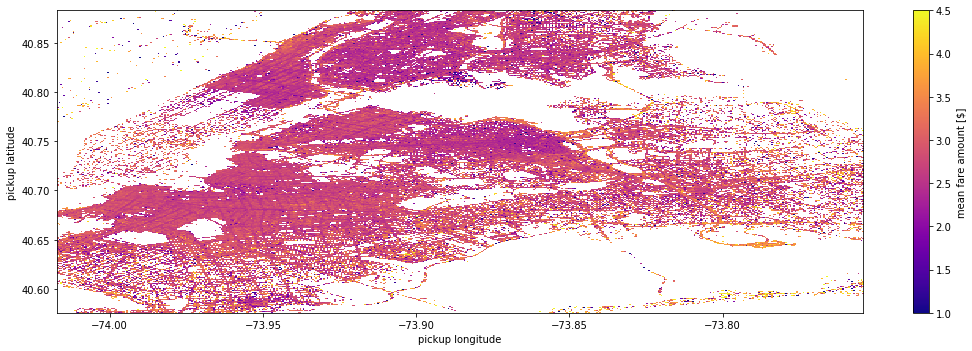

The slowest run took 4.45 times longer than the fastest. This could mean that an intermediate result is being cached.
5.06 µs ± 3.72 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
plt.figure(figsize=(15, 5))
df_filtered_vaex.plot('pickup_longitude', 'pickup_latitude', what='mean(fare_amount)',
                 colormap='plasma', f='log1p', shape=512, colorbar=True, 
                 colorbar_label='mean fare amount [$]', vmin=1, vmax=4.5)

plt.xlabel('pickup longitude')
plt.ylabel('pickup latitude')
%timeit plt.show()

### Reading data from Dask hdf

### Below code is makedown, beacuse it is running for long time and not givening any output for hvplot. 

import hvplot.dask
import holoviews as hv
hv.extension('bokeh')

df_dask_read.hvplot.heatmap(x='pickup_latitude', y='pickup_longitude', C='fare_amount', reduce_function=np.mean, colorbar=True)

# Analysis:

Vaex: 5.06 µs ± 3.72 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

Vaex is supporting and giving heatmap outout for large dataset, Where as pandas can not handle large data set and gives memory error while ploting heatmap.And for dask it is also not working as it is running for long period of time and not showing any output. 
So vaex performance is better and faster than pandas and dask.

## 4. Compute the arc distance for the filtered data and plot the distribution number of trips of trip distance and arc distance.

### Reading data from Pandas hdf

In [37]:
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

%timeit panda_hdf_read['arc_distance'] = arc_distance(panda_hdf_read.pickup_longitude, panda_hdf_read.pickup_latitude, panda_hdf_read.dropoff_longitude, panda_hdf_read.dropoff_latitude)
panda_hdf_read

7.42 s ± 2.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


,passenger_count,trip_distance,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,arc_distance
2199566,1.0,0.00,7.0,-73.865013,40.826099,-73.864990,40.826099,0.001581
2199567,1.0,0.00,52.0,-73.987335,40.692123,-73.987328,40.692123,0.000527
2199568,1.0,0.25,3.0,-73.949959,40.827183,-73.952377,40.824036,0.177589
2199569,1.0,0.04,2.5,-73.944977,40.808582,-73.945923,40.807316,0.069702
2199570,1.0,0.26,3.0,-73.951561,40.812111,-73.952171,40.812458,0.042690
...,...,...,...,...,...,...,...,...
75903985,1.0,5.00,15.0,-73.997559,40.691139,-73.940086,40.723503,4.018722
75903986,2.0,2.10,9.0,-73.890846,40.746918,-73.862122,40.739246,1.990156
75903987,1.0,6.40,25.0,-73.956848,40.722839,-74.004005,40.721066,3.258466
75903988,4.0,4.60,19.5,-73.981323,40.675045,-73.992836,40.724155,1.228386


(array([1.9864341e+07, 1.1827900e+07, 5.7331810e+06, 2.8237070e+06,
        1.3604720e+06, 7.5724200e+05, 4.2987900e+05, 2.4850700e+05,
        1.8163700e+05, 1.2737300e+05, 9.3087000e+04, 1.1361100e+05,
        9.6339000e+04, 4.7350000e+04, 3.8636000e+04, 1.5651000e+04,
        7.9220000e+03, 3.6560000e+03, 2.1130000e+03, 1.4220000e+03,
        1.0640000e+03, 1.1170000e+03, 1.1670000e+03, 7.9000000e+02,
        5.0900000e+02, 4.8400000e+02, 3.8800000e+02, 3.3900000e+02,
        2.5000000e+02, 2.3200000e+02, 1.9600000e+02, 1.9600000e+02,
        1.6500000e+02, 1.7000000e+02, 1.4400000e+02, 1.2100000e+02,
        1.3000000e+02, 1.1000000e+02, 8.9000000e+01, 8.3000000e+01,
        5.6000000e+01, 6.6000000e+01, 9.0000000e+01, 4.9000000e+01,
        5.0000000e+01, 4.3000000e+01, 5.3000000e+01, 6.7000000e+01,
        6.7000000e+01, 5.1000000e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.

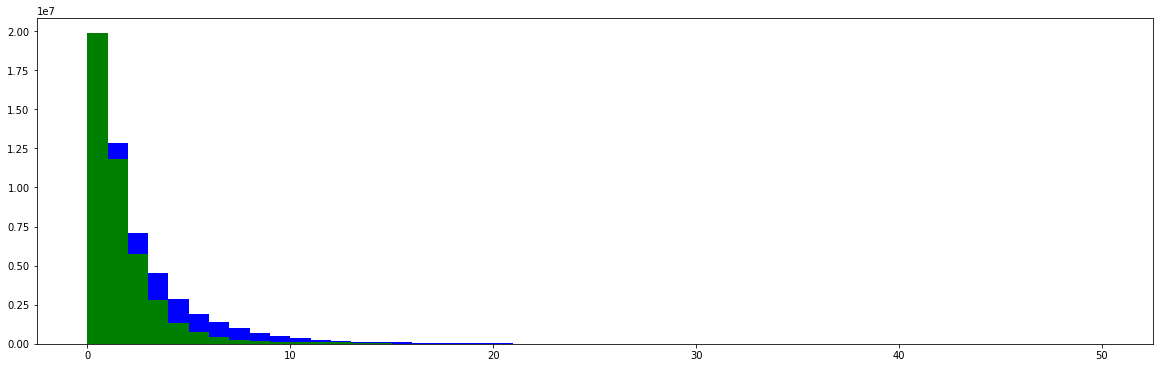

In [34]:
plt.figure(figsize=(20,6))
plt.hist(panda_hdf_read.trip_distance, 50, range=[0,50], facecolor='blue',align='mid')
plt.hist(panda_hdf_read.arc_distance, 50, range=[0,50], facecolor='green', align='mid')

### Reading data from Vaex hdf

In [36]:
def arc_distance_vaex(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

%timeit df_vaex['arc_distance'] = arc_distance_vaex(df_vaex.pickup_longitude,df_vaex.pickup_latitude,df_vaex.dropoff_longitude, df_vaex.dropoff_latitude).jit_numba()
df_vaex

134 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#,passenger_count,trip_distance,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,arc_distance
0,1.0,0.0,7.0,-73.8650131225586,40.82609939575195,-73.864990234375,40.82609939575195,0.0015814383185108532
1,1.0,0.0,52.0,-73.98733520507811,40.69212341308594,-73.98732757568358,40.69212341308594,0.0005271461061702844
2,1.0,0.25,3.0,-73.94995880126955,40.82718276977539,-73.95237731933594,40.82403564453125,0.17758936355992336
3,1.0,0.04,2.5,-73.94497680664062,40.8085823059082,-73.9459228515625,40.807315826416016,0.06970202661782768
4,1.0,0.26,3.0,-73.9515609741211,40.812110900878906,-73.95217132568358,40.81245803833008,0.042689761812471666
...,...,...,...,...,...,...,...,...
"43,878,099",1.0,5.0,15.0,-73.99755859375,40.691139221191406,-73.9400863647461,40.72350311279297,4.018721847134041
"43,878,100",2.0,2.1,9.0,-73.8908462524414,40.746917724609375,-73.86212158203125,40.7392463684082,1.9901561833989574
"43,878,101",1.0,6.4,25.0,-73.95684814453125,40.72283935546875,-74.0040054321289,40.72106552124024,3.258465626181178
"43,878,102",4.0,4.6,19.5,-73.9813232421875,40.67504501342773,-73.99283599853516,40.72415542602539,1.228385581946478


[#########################---------------] 100.00% elapsed time  :     0.23s =  0.0m =  0.0h
[#######################################-] 100.00% elapsed time  :     1.81s =  0.0m =  0.0h
[###############################---------] 100.00% elapsed time  :     0.80s =  0.0m =  0.0h
 

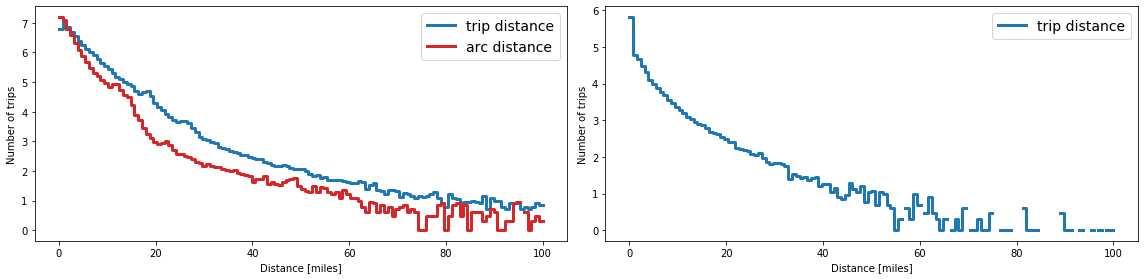

In [38]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
df_vaex.plot1d('trip_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C0', 
                   label='trip distance', progress=True)
df_vaex.plot1d('arc_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C3', 
                   label='arc distance', progress=True)
plt.legend(fontsize=14)
plt.xlabel('Distance [miles]')
plt.ylabel('Number of trips')


plt.subplot(122)
df_vaex.plot1d('trip_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C0', 
                   selection='arc_distance<0.06', label='trip distance', progress=True)
plt.legend(fontsize=14)
plt.xlabel('Distance [miles]')
plt.ylabel('Number of trips')


plt.show()

### Reading data from Dask hdf

In [9]:
def arc_distance_dask(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

%timeit df_dask_read['arc_distance'] = arc_distance_dask(df_dask_read.pickup_longitude, df_dask_read.pickup_latitude, df_dask_read.dropoff_longitude, df_dask_read.dropoff_latitude).astype(int)

The slowest run took 4.40 times longer than the fastest. This could mean that an intermediate result is being cached.
89.7 ms ± 40.9 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
df_dask_plot = df_dask_read.compute()
df_dask_plot

,passenger_count,trip_distance,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,arc_distance
2199566,1.0,0.00,7.0,-73.865013,40.826099,-73.864990,40.826099,0
2199567,1.0,0.00,52.0,-73.987335,40.692123,-73.987328,40.692123,0
2199568,1.0,0.25,3.0,-73.949959,40.827183,-73.952377,40.824036,0
2199569,1.0,0.04,2.5,-73.944977,40.808582,-73.945923,40.807316,0
2199570,1.0,0.26,3.0,-73.951561,40.812111,-73.952171,40.812458,0
...,...,...,...,...,...,...,...,...
75903985,1.0,5.00,15.0,-73.997559,40.691139,-73.940086,40.723503,4
75903986,2.0,2.10,9.0,-73.890846,40.746918,-73.862122,40.739246,1
75903987,1.0,6.40,25.0,-73.956848,40.722839,-74.004005,40.721066,3
75903988,4.0,4.60,19.5,-73.981323,40.675045,-73.992836,40.724155,1


(array([1.9864341e+07, 1.1827900e+07, 5.7331810e+06, 2.8237070e+06,
        1.3604720e+06, 7.5724200e+05, 4.2987900e+05, 2.4850700e+05,
        1.8163700e+05, 1.2737300e+05, 9.3087000e+04, 1.1361100e+05,
        9.6339000e+04, 4.7350000e+04, 3.8636000e+04, 1.5651000e+04,
        7.9220000e+03, 3.6560000e+03, 2.1130000e+03, 1.4220000e+03,
        1.0640000e+03, 1.1170000e+03, 1.1670000e+03, 7.9000000e+02,
        5.0900000e+02, 4.8400000e+02, 3.8800000e+02, 3.3900000e+02,
        2.5000000e+02, 2.3200000e+02, 1.9600000e+02, 1.9600000e+02,
        1.6500000e+02, 1.7000000e+02, 1.4400000e+02, 1.2100000e+02,
        1.3000000e+02, 1.1000000e+02, 8.9000000e+01, 8.3000000e+01,
        5.6000000e+01, 6.6000000e+01, 9.0000000e+01, 4.9000000e+01,
        5.0000000e+01, 4.3000000e+01, 5.3000000e+01, 6.7000000e+01,
        6.7000000e+01, 8.4000000e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.

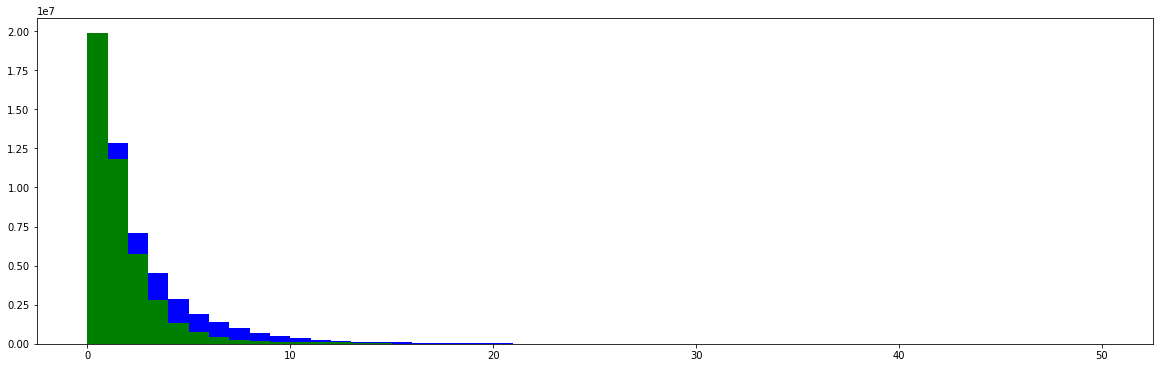

In [8]:
plt.figure(figsize=(20,6))
plt.hist(df_dask_plot.trip_distance, 50, range=[0,50], facecolor='blue',align='mid')
plt.hist(df_dask_plot.arc_distance, 50, range=[0,50], facecolor='green', align='mid')

# Analysis:

Vaex: 134 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each), so runtime will be around 0.134 s

Dask: 89.7 ms ± 40.9 ms per loop (mean ± std. dev. of 7 runs, 100 loops each),so runtime will be around 8.9 s

Pandas: 7.42 s ± 2.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each), so runtime will be around 7.42 s

As per the above runtime analysis, vaex is faster than daks and pandas with green taxi data.

# Conclusion: 

Dask and vaex supports the Pandas dataframe. Dask DataFrame is made up of smaller split up Pandas dataframes and therefore allows a subset of Pandas query syntax. Vaex feels like Pandas for the basics, but adds new ideas that are useful for really large datasets.So as per the above analysis we can say Vaex has a strong focus on large datasets than dask and pandas.

Reference:

https://towardsdatascience.com/why-every-data-scientist-should-use-dask-81b2b850e15b

https://medium.com/@maartenbreddels/dask-and-vaex-are-not-competing-they-are-orthogonal-ece0f1fb133c

60/60